In [5]:
%run ../Config/ImgConfig.ipynb
HTML("""<style>.jp-OutputArea-output {display: table-cell;text-align: center !important;vertical-align: middle !important;}.jp-OutputArea-output img {width: 70% !important;}</style>""")

# 2. Literature Review

[index](../Index.ipynb) | [prev](./01.Introduction.ipynb) | [next](./03.SystemDesign.ipynb)

This chapter provides a theoretical foundation for the key ideas and algorithms, which can be found inside this research. 

**Note:** Code samples used to generate included plots can be found in the corresponding [Extra Notebook 1](../Notebooks/Extra.01.LiteratureReview.ipynb)

## 2.1. Data Collection

Data Collection involves a mini-computer (Raspberry Pi) which streams the data to the central unit (a Ubuntu-based Desktop PC with a GPU), which runs an infinite loop with the two key algorithms:
- Background subtraction
- Yolo Object Recognition

Both of these algorithms are extremely useful in the image processing applications, and they represent a foundation of how data is collected in the system.

### 2.1.1. Motion Detection

Considering how objects of interest could be detected in high frame per second (**FPS**) video stream, a naive approach would be to send all frames into an Object Detector.

In theory this would work, but it would be extremely inefficient and resource intensive.

The optimization comes by detecting a significant change in a series of images, and only then sending frames to an Object Detector for further analysis.

Here is an example of a static background, where nothing interesting is happening:

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.1. Static background</p>

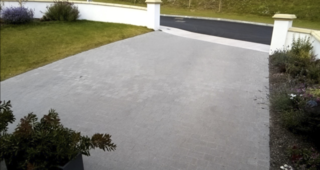

In [3]:
Image(filename="../Resources/img/no-motion.png")

And now a moving object (a person running) in a 7 consecutive frames:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.2. Moving object</p>

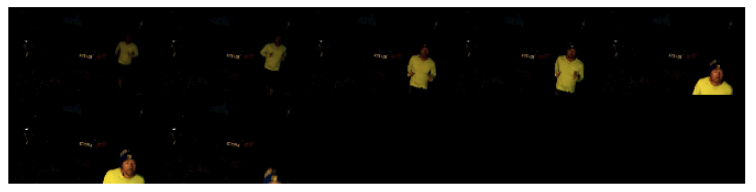

In [4]:
Image(filename="../Resources/img/moving-object.png")

It turns out that there is already a set of well established algorithms in the Computer Vision domain designed precisely for that purpose. They are not $100\%$ accurate, but they do not need to be. If they can help to reject over $90\%$ of static frames, then GPU can be allocated to other tasks or simply kept idle to extend its lifespan. In addition, the machine will be more quiet and it will generate less heat.

One of the most popular and successful methods for motion detection in images is the *Background Subtraction*.

At a very high level the concept is very simple: there is a starting point with a static image without any moving objects (called *background* - $\text{BG}$). Then, every consecutive frame will be compared against the background to detect any changes in the *foreground* - $\text{FG}$.

Unfortunately, there are many challenges in this optimistic approach:

- the initial background might already contain moving objects
- next frames actually do not contain any moving objects, but only changes in light illumination
- shadows appear and disappear
- camera is in-door and light is turned on and off
- tree branches move in the background
- changing weather conditions (rain, snow, hail)
- small objects constantly show in the camera lens

These, not so rare anomalies demand a more sophisticated approach than just a simple subtraction of foreground from the background.

One very popular improvement over the vanilla algorithm has been proposed in the *Improved Adaptive Gaussian Mixture Model for Background Subtraction* paper <cite data-cite="zivkovic:2004:subtraction">(Zivkivoc 2004)</cite>. The aim of Zivkivoc’s work was to overcome some of the challenges above and achieve efficiency by reducing the processing time.

In the *MOG2* model, the background is constantly updated and not static. As author describes it, it uses recursive equations to constantly update parameters and also select appropriate number of components per each pixel. At a high level author describes a metric $R$ (using a Bayesian decision), which follows the formula:

$$
R=\frac{p(\text{BG}|\mathbf{x}^{(t)})}{p(\text{FG}|\mathbf{x}^{(t)})}=\frac{p(\mathbf{x}^{(t)}|\text{BG})p(\text{BG})}{p(\mathbf{x}^{(t)}|\text{FG})p(\text{FG})}
$$

, where the aim is to determine the ratio between the probability of new pixel at time $t$ being a foreground or a background.

In general prior information about $FG$ is unknown, it is a uniform distribution. Then, a decision is made if object is a $BG$ if the probability of $x$ at time $t$, given $BG$ is greater than some threshold value ($c_{thr}$):

$$
p(\mathbf{x}^{(t)}|BG) > (=Rc_{FG})
$$

The left side of the equation is referred to as a background model. It depends on the training set denoted as $X$.

In order to eliminate the problem of suddenly changing lighting factor, authors proposed to keep updating the training set by dropping old values, appending new ones and re-estimating the background model (using Gaussian mixture model with $M$ components):

$$
\hat{p}(\mathbf{x}|X_T,BG+FG)=\sum^{M}_{m=1}\hat{\pi}_m \mathcal{N}(\mathbf{x};\hat{\boldsymbol{\mu}}_m,\hat{\sigma}^2_mI)
$$

Where means and variances, which describe the Gaussian components are added. Covariance matrices are
diagonal and identity matrix has proper dimensions. The weights are non-negative and add up to 1.

For each new data samples, equations are updated recursively, as follows:

$$
\hat{\pi}_m \leftarrow \hat{\pi}_m + \alpha(o^{(t)}_m-\hat{\pi}_m)
$$

$$
\hat{\boldsymbol{\mu}}_m \leftarrow \hat{\boldsymbol{\mu}}_m + o^{(t)}_m (\alpha/\hat{\pi}_m)\boldsymbol{\delta}_m
$$

$$
\hat{\sigma}^2_m \leftarrow \hat{\sigma}^2_m + o^{(t)}_m(\alpha/\hat{\pi}_m)(\boldsymbol{\delta}^T_m \boldsymbol{\delta}_m  - \hat{\sigma}^2_m)
$$

There is an introduction of an $\alpha$ - alpha parameter here, which is exponentially decaying, meaning that the older
data samples will be given less importance:

$$
\alpha=1/T
$$

In the new sample the $o_m^{(t)}$ value is set to $1$ for the component with a largest weight and $0$ in other
components.

The following formula denotes the squared distance from m-th component:

$$
\boldsymbol{\delta}_m^T \boldsymbol{\delta}_m / \hat{\sigma}^2_m
$$

If the maximum number of components is reached, the component with the lowest weight is removed. Hence
the algorithm has been defined by the author to be an "online clustering algorithm".

Author also describes how model deals with the foreground objects, which remain static for a longer duration of time: for the $\text{FG}$ object to be considered a $\text{BG}$, it needs to be static for approximately some number of frames:

$$
log(1-c_f)/log(1-\alpha)
$$

$c_f$ stands for the maximum portion of data, which belongs to $\text{FG}$ objects without influencing the $\text{BG}$ model.
For sample values for $c_f$ and $\alpha$, author has calculated $105$ frames for the $\text{FG}$ object to be
considered a $\text{BG}$.

Weights define the underlying multinomial distribution. After additional derivations, author rewrites the first
equation to the following form (this is after including the *Dirichlet* prior for multinomial distribution):

$$
\hat{\pi}_m \leftarrow \hat{\pi}_m + \alpha(o^{(t)}_m-\hat{\pi}_m) - \alpha c_T
$$

Although the algorithm is very accurate, it has some trade offs and prerequisites need to be met:

- frame needs to be stationary
- it is highly recommended to resize images (in theory, this is not a strong requirement, but this model is very slow when used with the $\text{1080p}$ or even $\text{720p}$ image resolution)

The OpenCV implementation for Python can be found under `cv2.createBackgroundSubtractorMOG2` function, which I have used to detect motion between consecutive image frames.

The parameters used for detection will be explained in the later Chapter: [Data Collection](./04.DataCollection.ipynb).

### 2.1.2. Object Detection

Once motion is detected, resized frames can be sent to an Object Detector to analyze the content of an image.

Object detection comes from two fundamental ideas in Computer Vision:

- Image Classification (look at an image and classify a single class: Car, Person, Dog etc.)
- Object Localization (where an object is located inside an image)

Object Detection's task is to classify multiple objects in an image and tell their locations.

Here is an example screen-shot from a web application, which I have built for this purpose. It detected motion and a single *Person* object in a real time camera stream:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.3. Real time detection in Web App</p>

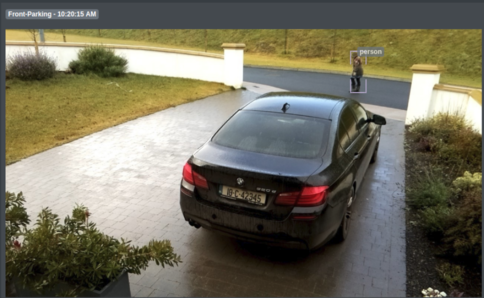

In [9]:
Image(filename="../Resources/img/person-detected.png")

In *Fig. 2.3* there is a person walking by in front of the parking area. There is a purple rectangle around the person, called the *bounding box*. If there were more people in the frame, they would be contained in their own bounding boxes too.

Object Detection is a dynamically evolving field with new algorithms and applications developed at high frequency. This is an advantage, as it creates new opportunities, but it is also a challenge for practitioners to keep up with the fast pace of change.

Out of two arguably most popular options for object detection in Python: *Yolo* and *SSD*, I have decided to use Yolo (You Only Look Once) due to the fact that it can be run in real time on a GPU at $30+$ frames per second with good online documentation and wide-spread adoption rate. In comparison - I have not found a GPU implementation for the SSD (Single Shot Detector) algorithm, and the amount of web based knowledge about it is lacking.

One could attribute Yolo's popularity to its catchy name, but it is nevertheless a very useful and fast algorithm for object detection.

**Yolo V1:**

Even though in my research I have used Yolo Version 2 <cite data-cite="redmon:2017:yolov2">(Redmon et al., 2017)</cite>, the section below is dedicated to Yolo version 1 <cite data-cite="redmon:2016:yolo">(Redmon et al., 2016)</cite>, as it is the foundation for object detection, which utilizes multiple Computer Vision and Deep Learning paradigms.

Yolo v1 has been released in 2015 as a new approach to object detection, which promised extreme speed and making real time object detection a reality. This was a significant achievement in comparison to previous object detectors, like R-CNN <cite data-cite="girshick:2013:rcnn">(Girshick, 2013)</cite>, where a single image could take 20 seconds to get processed or even in comparison to more modern Fast R-CNN <cite data-cite="girshick:2015:fastrcnn">(Girshick et al., 2015)</cite>, which still took 2 seconds to process a single image and Faster R-CNN <cite data-cite="ren:2015:fasterrcnn">(Ren et al., 2015)</cite> with 0.14 second per frame.

The processing time can be extremely important for certain applications, like self driving car or camera monitoring system. According to Yolo authors, algorithm can run at $45$ frames per second with a slight decrease in accuracy for smaller objects.

To visualize progress in the area, I have put together a table below:

| Detector      | FPS |
| ------------- | --- |
| R-CNN | 0.05 |
| Fast R-CNN  | 0.5 |
| Faster R-CNN | 7 |
| Yolo v1 | 45 |

Yolo owes the gain in speed to a complete re-engineering of how the object detectors can operate.

Traditional methods used previously, like: a sliding window with HOG (Histogram of Oriented Gradients); SVM (Support Vector Machine); and region proposals (seen in R-CNN's); required potentially thousands of iterations through a single image.

In contrast, Yolo uses only a single pass through the entire image to generate predictions.

Then, to get rid of overlapping bounding boxes, the ones with very low probability are discarded, and Non-max suppression <cite data-cite="hosang:2017:suppression">(Hosang et al., 2017)</cite> algorithm is applied.

This approach generates an output of $1470$ features, containing all the data needed to understand the content of an image. Assuming $20$ object classes, the calculation is as follows:

$$
7\times7\times(2\times5+20) = 7\times7\times30\text{tensor} = 1470\text{features}
$$

, where $7\times7$ is related to a grid size, which image is divided by, $2\times5$ stands for 2 bounding boxes inside each grid cell, and $20$ is a number of predicted classes in a One Hot Encoded notation.

Each grid cell predicts two boxes and can only have a single class.

Below is the name and description for each of the 5 nodes found in each bounding box:

- $Conf$ - confidence
- $x$ - x coordinate of center of the box (relative to grid cell)
- $y$ - y coordinate
- $w$ - width of the box (relative to whole image)
- $h$ - height

The confidence if object is present in the grid is calculated as:

$Pr(\text{Object}) \cdot \text{IOU}^{\text{truth}}_{\text{pred}}$

, where $\text{IOU}$ represents an Intersection Over Union, an evaluation metric for bounding boxes:

$$
\text{IOU}=\frac{\text{areaOfOverlap}}{\text{areaOfUnion}}
$$

If there is no object present in the cell, then the confidence will be zero, but if there is an object, it will equal to the $IOU$ metric.

For training, a following Convolutional Neural network is used:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.4. Yolo v1 architecture</p>

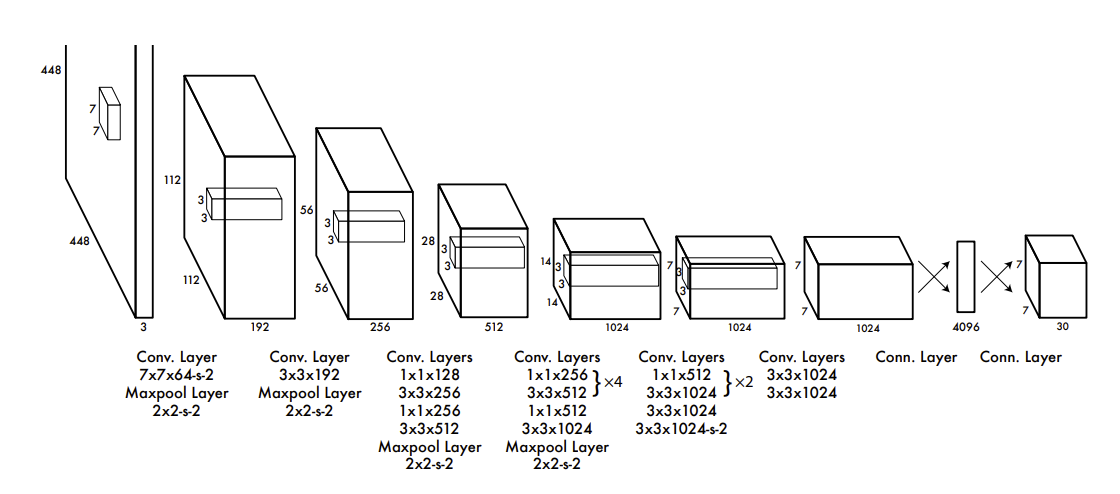

In [10]:
Image(filename="../Resources/img/yolo-v1-architecture.png")

, with $24$ convolutional layers followed by $2$ fully connected layers. Convolutional layers are pre-trained on ImageNet classification (with $1000$ classes), and final output is, as expected, a $7\times7\times30$ tensor.

This type of complex network was trained for a week using the freely available *Darknet* framework, which is also used for the real time inference in this research.

The network is trained with $224\times224$ image resolution and then extended to $448\times448$ at detection stage.

As activation function, authors have used a leaky rectified linear activation (Leaky ReLU):

$$
f(x)=\begin{cases}
x, & \text{if $x>0$}\\
0.1x, & \text{otherwise}
\end{cases}
$$

The loss function to optimize is a highly customized $\text{SumSquared Error}$ with the specific characteristics:

- to avoid issues with gradients for cells without any objects
- to distinguish errors in large boxes versus small boxes (errors in large boxes matter less)

Here are other significant training parameters:

- epochs: $135$
- batch size: $64$
- momentum: $0.9$
- decay: $0.0005$
- custom learning rate schedule

To prevent the overfit, dropout layers are introduced, and to increase image variability data augmentation is used.

Overall, Yolo is a good trade-off between speed and accuracy and at present is one of the most useful tools, which is free of cost and provides plethora of online documentation and examples.

**Yolo V2:**

An upgraded version of Yolo (V2) was released in 2016 as a state of the art real time object detector capable of detecting over $9000$ object categories.

Capable of achieving a $76.8$ mAP (mean average precision) on VOC 2007 (The PASCAL Visual Object Classes Challenge 2007) while maintaining $40$ FPS, which, as authors conclude, outperforms the other two most populate object detectors: *SSD* and *Faster RCNN with ResNet*.

The main improvements in Yolo v2 have been achieved through a number of core ideas:

- Batch Normalization: Added to all convolutional layers to stabilize training, speed up convergence and add regularization
- High Resolution Classifier: End to end fully trained on $448\times448$ image resolution, so more details can be detected
- Convolutional With Anchor Boxes: Diving an image into N-overlapping boxes of $\text{W}x\text{H}$ size - helpful to detect smaller objects, like multiple people faces
- Dimension Clusters: Instead of hand picked anchor box dimensions, Yolo V2 uses k-means clustering with a custom distance metric $d(box,centroid)=1-IOU(box,centroid)$
- Direct location prediction: Increase model stability during early training iterations by introducing logistic activation to constrain network predictions or coordinates relative to the location of the cell grid
- Multi-Scale Training: Aim is to make the model robust to varied image resolutions, which is achieved by randomly choosing a new image dimension every 10 batches during the training (size must be divisible by 32, from $320\times320$ to $608\times608$. When Yolo is run at $288\times288$, it achieves much better performance, which might be useful for multiple video streams (for example one camera inside and two outside the house)

The architecture is composed of $19$ convolutional layers and $5$ max-pooling layers. To process an image $5.58$ billion operations is required. This might seem very high, but it is much lower in comparison to a very popular choice for feature extractor VGG-16 <cite data-cite="simonyan:2014:recognition">(Simonyan et al., 2014)</cite>, which require $30.69$ billion floating point operations. Yolo V1 required $8.52$ billion, as it was based on the Googlenet architecture <cite data-cite="szegedy:2014:going">(Szegedy et al., 2014)</cite>.

Yolo V2 uses its own classification model called *Darknet-19*, which is trained for classification and for detection using slightly different architecture and hyper-parameters from V1 and similar data augmentation techniques to V1.

The *classification model* uses ImageNet dataset with $1000$ very fine-grained classes (like "Norfolk terrier") and *detection model* uses COCO dataset with $80$ high-level class names (like "dog").

Since authors wanted to jointly train on classification and detection data, a *hierarchical classification* was used, where the final soft-max layer with the flat encoding of mutually exclusive labels is not assumed. This has been achieved using an approach borrowed from Natural Language Processing called *WordTree*, where for each lower level class, a probability is calculated if this class belongs to a broader category, example:

$$
Pr(Norfolk-terrier|terrier)
$$

This model can been visualized as the following tree diagram:

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.5. Yolo V2 WordTree</p>

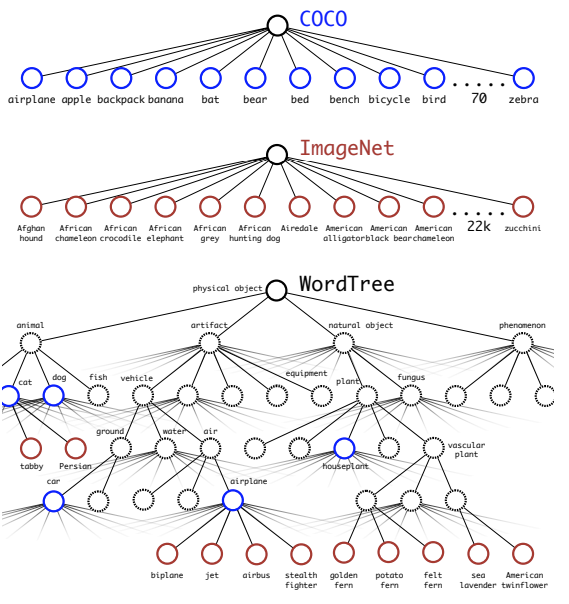

In [11]:
Image(filename="../Resources/img/word-tree.png")

**Yolo V3, V4:**

Since 2018 there have been already two iterations for Yolo object detector:

- version 3 <cite data-cite="redmon:2018:yolov3">(Redmon et al., 2018)</cite>
- version 4 <cite data-cite="bochkovskiy:2020:yolov4">(Bochkovskiy et al., 2020)</cite>

They both look very promising in terms of further accuracy and performance boosts, but I am leaving this work for the future increments of this project.

### 2.1.3. Conclusion

Yolo V2 represents a good trade off between accuracy and performance, and has proven to work well in case of detecting people and vehicles from the Raspberry Pi camera frames, which I discuss further in the [Data Collection](./04.DataCollection.ipynb) chapter.

## 2.2. Forecasting

<a id="fcst-begin"></a>
In advance of discussions about Machine Learning models, I would like to point out a fundamental concept: *Bias and Variance trade-off*.

We say that a model is good if it fits the training and testing data well. Models like Linear Regression create a straight line through the data points, and often do not represent the relationships very well. This is called *High Bias*. On the other hand, learners like Decision Trees model relationships in the training data very well, but tend to perform poorly on the testing sets. We call this behaviour *High Variance*. Ideally we always look for a model with relatively low bias and low variance. In practice, it is a matter of finding a good trade-off.

Although the above statement tends to hold for non-Neural Network models, it does not always apply to Neural Networks, which can generalize well, even with their complexity and High Variance <cite data-cite="neal:2018:bias">(Neal et al., 2018)</cite>.

The Forecasting Chapter includes a study on a single *Naive* and three *Machine Learning* algorithms, which are compared next in the Literature Review:

- Standard Decision Tree
- Gradient Boosting Decision Tree
- Gaussian Process

As a side note, I have also explored many other algorithms, like:

- Linear Regression
- Random Forest
- Multiple variations of Feed Forward Neural Network
- Long Short Term Memory Recurrent Neural Network (LSTM)

Training so many Machine Learning models was a very valuable experience, but the additional algorithms listed above were not beneficial to the research results.

### 2.2.1. Decision Tree Regressor

*Decision Trees* are a building block for many more sophisticated Machine Learning algorithms. Their simplicity and interpretability make them a very popular choice, when decisions must be clearly understood and explained.

The history of Decision Trees used for regression problems is not very easy to track, and goes back to a research by J.N. Morgan <cite data-cite="morgan:1963:survey">(Morgan et al., 1963, p. 430)</cite> titled *Problems in the Analysis of Survey Data, and a Proposal*, where most likely first decision tree for regression was drawn. What has been a challenge back then (computational overhead) is actually not an issue in 2020, which makes Decision Trees one of the fastest Machine Learners available for relatively condensed datasets.

The problem with decision trees is their low accuracy on an out-of-sample datasets and low robustness (small changes in training data may easily lead to a very different tree). It is however useful to discuss their inner workings before moving on to the more advanced algorithms.

Here is an example output from a Tree Regressor algorithm run on a small subset of $100$ observations (for illustrative purpose) from the dataset with *People* detections:

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.6. Decision Tree</p>

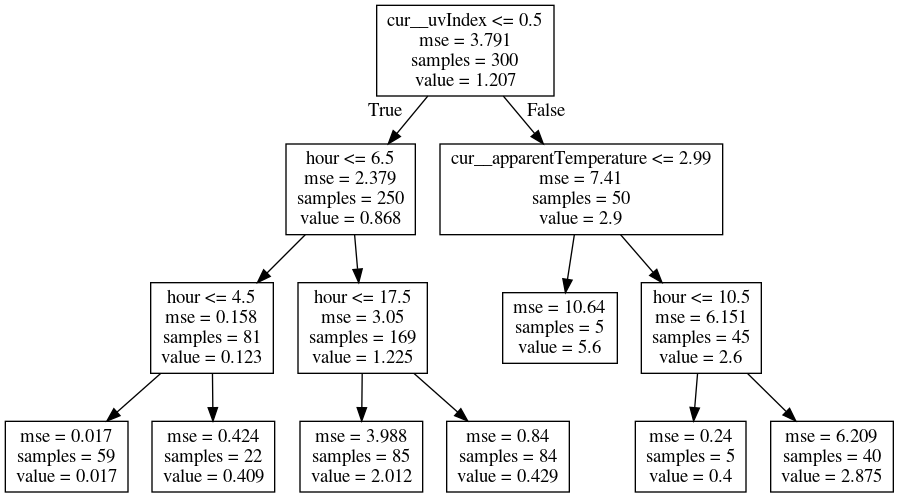

In [12]:
Image(filename="../Resources/img/tree.png")

This tree can be interpreted as a series of sub-decisions to reach a decision goal. Following the *right hand side path*, the model predicts a value of $2.875$ by making the following decisions:

- `uvIndex` is greater than $0.5$
- `temperature` is greater than $2.99$
- `hour` is greater than $10$

It intuitively makes sense, as during the day, when temperature is not very low and after 10AM, expectation of approximately $3$ objects is correct.

Below is the basic terminology related to the hierarchy above:

- the single box on top of the diagram is called a *root node*
- nodes in the middle are called the *decision nodes* and are connected by arrows creating a section called a *branch*
- the eight boxes in the bottom are *leaf nodes*

The best split for Regression Trees is usually calculated using *mean squared error*, however other metrics (like *mean absolute error*) can be utilized as well.

The top-down procedure to generate a tree is the same for each node:

- iterate through candidate features
- for each feature:
    - sort values
    - find average between each pair of values and use as a candidate split value
    - calculate average for values the left and right nodes
    - calculate squared residuals for each node
    - sum all residuals or average those
- split the data by the feature and value, which produces the lowest squared error
- keep doing this until:
    - reached maximum depth of a tree allowed
    - there is not enough samples to create a split
    - all samples contain the same value
- leaf nodes will eventually contain an average value for the target variable

Hyper-parameters `max_depth` and `min_samples_split` are used as a regularization term to avoid creating a model with *too high variance*.

### 2.2.2. Gradient Boosting Regressor Tree

There are many extensions to the base Decision Tree algorithm. I have found the Gradient Boosting Regressor to perform the best with the object detections dataset.

The *Histogram Based Gradient Boosting Regressor* is a relatively new estimator added in 2019 into the Sci-Kit Learn library, developed in *Cython* to optimize speed. It is very efficient and capable of handling large datasets and missing values.

The implementation in sklearn was inspired by the 2017 paper <cite data-cite="ke:2017:lightgbm">(Ke et al., 2017)</cite>: *LightGBM: A Highly Efficient Gradient Boosting Decision Tree* and it is a modern take on the original Gradient Boosting Machine algorithm by Jerome Friedman <cite data-cite="friedman:2001:gradient">(Friedman, 2001)</cite>.

The original algorithm developed by Friedman puts robustness as one of the most favorable characteristics. The paper also mentions that the TreeBoost removes the need for feature transformations, and chooses only important features, while ignoring irrelevant input variables. It handles missing data, and enhances stability through the use of many small trees (instead of a single large one). Author admits that single Decision Tree is easier to interpret than many (even hundreds) small trees, however when one tree grows to a very large scale, this conclusion does not hold any more.

Friedman's algorithm can be described in a sequence of steps:

- Start with a dataset consisting of input features and a target variable $\{(x_j, y_i)\}^n_{i=1}$ and a Loss Function, which is *differentiable* $L(y,F(x))$ (like *least squares*)
- Initialize a model with a constant value: $F_0(x)=\text{argmin}_{\gamma} \sum^n_{i=1}L(y_i,\gamma)$, solve this equation find the initial predictions by taking the derivatives for the losses for each target, summing them up and setting the sum to $0$. In the Decision Tree terminology, this step creates a leaf, which predicts the initial values
- Next section is an iteration for $m=1$ to $M$ which produces $M$ small trees (where $M$ is a hyper-parameter to tune), and contains following steps
    - Compute $r_{im} = -[\frac{\partial L(y_i,F(x_i))}{\partial F(x_i)}]_{F(x}=F_{m-1}(x)$ for $i=1,...,n$
    - Fit regression tree to the $r_{im}$ values and create terminal regions $R_{jm}$ for $j=1...J_m$
    - For $j=1,...,J_m$ compute $\gamma_{jm}=\text{argmin}_{\gamma} \sum_{x_i \in R_{ij}} L(y_j,F_{m-1}(x_i)+\gamma)$
    - Update $F_m(x)=F_{m-1}(x)+\nu \sum^{J_m}_{j=1}\gamma_m I(x \in R_{jm})$, where $\nu$ is another hyper-parameter to tune, the learning rate
- The iteration stops when either all steps were exhausted or when there is no significant change in the errors

The key idea in the *Histogram Based Gradient Boosting* is related to the way Decision Trees find the best value to split the data. Where vanilla Gradient Boosting algorithm sorts the values and then for each pair of values runs a test if the split is optimal, histogram based Tree avoids the computational problem for larger datasets by binning the values into (typically) $256$ bins and use integer-based data structures (histograms). This way expensive sorting and testing all continuous floating point values is avoided.

One of the most recent improvements in this algorithm in `sklearn` is a *Poisson* loss function, which is more suitable when data is believed to come from a Poisson distribution (adequate for count data):

$$
L(y,\hat{y})=\frac{1}{N}\sum^N_{i=0}(\hat{y}_i-y_i \text{log} \hat{y}_i)
$$

, where $\hat{y}$ is the predicted expected value and $y$ is the ground truth value.

As per Wikipedia definition <cite data-cite="wiki:poisson">(Poisson distribution, n.d.)</cite>, Poisson is a discrete probability distribution, which expresses the probability of a given number of events occurring in a fixed interval of time or space if these events occur with a known constant mean rate and independently of the time since the last event.

Probability mass function of $X$ for $k=0,1,2,3, ...$ is given by:

$$f(k;\lambda) = Pr(X=k) = \frac{\lambda^{k} e^{-\lambda}}{k!})$$

, where $\lambda>0$, *expected value* and *variance* are both equal to $\lambda$, $e$ is Euler's number ($e=2.718...$) and $k!$ is the factorial of $k$.

Minimizing the Poisson loss is equivalent of maximizing the likelihood of the data under the assumption that the target comes from a Poisson distribution, which is conditioned on the input.

This feature is utilized in the [Forecasting Notebook](./05.Forecasting.ipynb).

### 2.2.3. Gaussian Process

Gaussian Distribution, also known as Normal Distribution is the cornerstone of statistical learning.

Its origins go back to the theory with Abrhama de Moivre (1667-1754) and Carl Friedrich Gauss (1777-1855), and it is a fundamental concept used to model real-valued, random and continuous variables, which can be observed vastly in the nature, social studies, mathematics and engineering.

The Central Limit Theorem <cite data-cite="springer:2008:central">(sirname, year)</cite>(Springer 2008) and unique analytical properties make Gaussian distributions a very useful tool, which can be also applied to Machine Learning.

The literature review below takes a gradual approach in order to understand the Gaussian Processes:

- Univariate Gaussian Distribution
- Multivariate Gaussian Distribution
- Gaussian Process

It is interesting for this research, as Gaussian Process can be used not only to make future predictions given the historical data, but also to highlight the uncertainty about these predictions, which allows for more informed decisions.

**Univariate Gaussian**

As clearly defined by Peter Roelants <cite data-cite="roelants:2020:multivariate">(Roelants, 2020)</cite> in his blog article, Gaussian distribution is given by:$\mathcal{N}(\mu, \sigma^2)$, where $\mu$ is the expected value of a distribution, and $\sigma$ corresponds to a standard deviation from $\mu$. Sigma squared ($\sigma^2$) is also known as a variance.

The $pdf$ (probability density function) for a normal distribution is given by:

$$
p(x|\mu,\sigma)=\frac{1}{\sqrt{2\pi \sigma^2}}exp(-\frac{(x-\mu)^2}{2\sigma^2})
$$

The word "univariate" relates to a single random variable ($x$) in the equation above. Several values for $\mu$ and $\sigma$ can be plotted to observe the familiar *bell curves*:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.7. Univariate Gaussian</p>

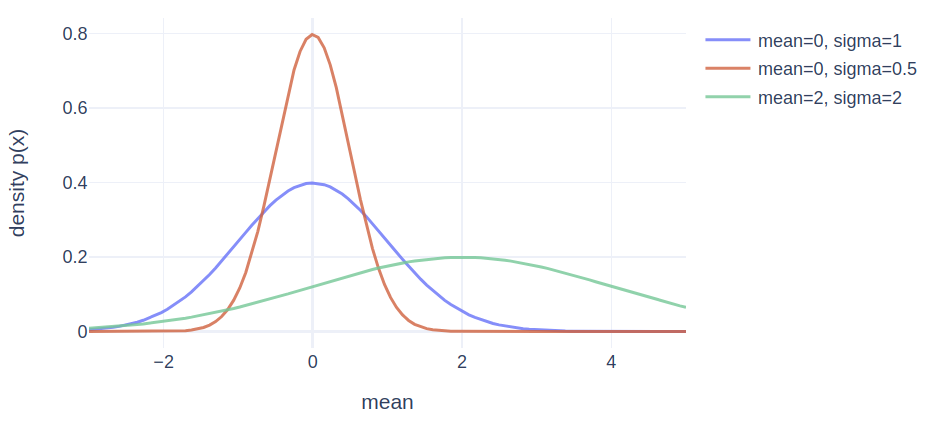

In [13]:
Image("../Resources/img/gaussian-uni.png")

**Multivariate Gaussian**

Multivariate normal distribution is used for analysis of multiple random variables (for example $x_1$ and $x_2$). Similarly to the univariate case, it is defined by a two parameters:

- mean vector $\mu$
- covariance matrix $\Sigma$, which measures how correlated each pair of variables is

The equation below describes a join probability for the multivariate normal with $d$ variables (i.e. the dimension of the dataset):

$$
p(x|\mu,\Sigma)=\frac{1}{\sqrt{(2\pi)^2|\Sigma|}}exp(-\frac{1}{2}(x-\mu)^T \Sigma^{-1} (x-\mu))
$$

, where $x$ is this time a vector of values (of size $d$), $\Sigma$ is the symmetric and positive definite covariance matrix (of size $dxd$), and $|\Sigma|$ is its determinant.

As a shorthand, we use $\mathcal{N}(\mu, \Sigma)$ to denote this distribution.

Below are a two examples of multivariate Gaussian distribution:

- first example shows 2 uncorrelated variables. Change in $x_1$ does not mean a change in $x_2$ ($0, 0$ diagonals in $\Sigma$):

$$
\mathcal{N}\left(\begin{bmatrix} 0 \\ 0 \end{bmatrix}, \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix}\right)
$$

- second example shows 2 highly correlated variables. When $x_1$ increases, $x_2$ will increase also ($0.9, 0.9$ diagonals in $\Sigma$):

$$
\mathcal{N}\left(\begin{bmatrix} 1 \\ 2 \end{bmatrix}, \begin{bmatrix} 1 & 0.9 \\ 0.9 & 1 \end{bmatrix}\right)
$$

<p style="text-align: center; margin-bottom: 5px;">Fig. 2.8. Bivariate Gaussian</p>

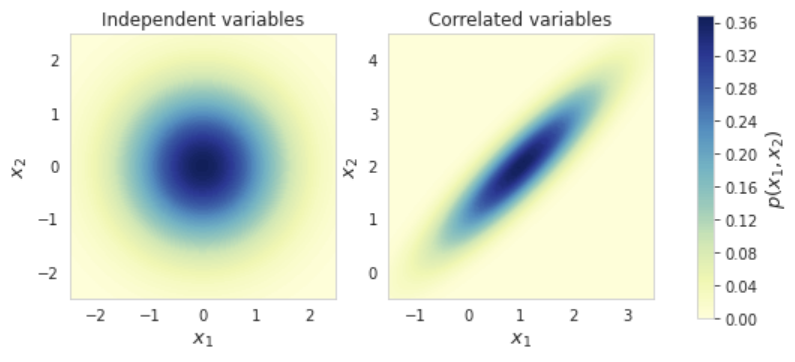

In [14]:
Image("../Resources/img/gaussian-multi.png")

Sampling from a multivariate distribution can be done by sampling from the standard normal $X~\mathcal{N}(0, I_d)$, where $\mu=0$ and covariance is the identity matrix $I_d$.

*Affine transformation* is applied to $X$, where $Y=LX+\mu$ and covariance $\Sigma_y=LL^T$ (we can omit the $\Sigma$ from the affine transform, as it is an identity matrix.

The next step is to find $L$ and this is done using a technique called the *Cholesky decomposition* (Cholesky 1910), which allows for efficient numerical solutions.

A pseudo-code below to sample from the Correlated examples is included in the Extra Notebook [here](../Notebooks/Extra01.LiteratureReview.ipynb#sample-corr):

The conditional distribution for $x$ given $y$ is defined as $p(x|y)=\mathcal{N}(\mu_{x|y}, \Sigma_{x|y})$, with:

$$
\mu_{x|y}=\mu_x+CB^{-1}(y-\mu_y)
$$

$$
\Sigma_{x|y}=A-CB^{-1}C^T=\tilde{A}^{-1}
$$

, with the symbols explained below:

$$
\begin{bmatrix} x \\ y \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_x \\ \mu_y \end{bmatrix}, \begin{bmatrix} A & C \\ C^T & B\end{bmatrix}\right) = \mathcal{N}(\mu, \Sigma)
$$

Pseudo-code to find means and covariances is also included in the Extra Notebook.

**Gaussian Process**

As per definition from Wikipedia <cite data-cite="wiki:gp">(Gaussian process, n.d.)</cite>, Gaussian Process is a stochastic process, involving random variables, represented by a multivariate normal distribution. It is a joint distribution over infinitely many random variables, and as such, it is a distribution over functions $f(x)$ with a continuous domain.

When used in Machine Learning context, kernel function, which measures similarity between points is used to predict values for unseen observations.

A practical benefit from such an approach is that the result is not only a point estimate, but also a range of standard deviations $\sigma$, which can be interpreted as an uncertainty.

Difference between the multivariate Gaussian and Gaussian process is that Gaussian processes operate on $mu$ and $\Sigma$ defined as a function, which removes the limitation of the finite number of jointly distributed Gaussians.

Gaussian process is defined as:

$$
f(x) \sim \mathcal{GP}(m(x), k(x,x'))
$$

, where $m(x)$ is a mean function and $k(x,x')$ is a covariance function.

In the Bayesian language, selecting the specification for the covariance function (called the kernel function), is setting a prior information. Kernel needs to be positive-definite to be a valid function.

The most commonly seen kernel function is the *Exponential Quadratic* ($RBF$ kernel), which produces a smooth function (see figure 2.9. below), and this is in fact the function used in this research. It is given by:

$$
k(x_a, x_b)=exp(-\frac{1}{2\sigma^2}\|x_a-x_b\|^2)
$$

One can sample from prior using a finite number of points and this results in a marginal distribution that is Gaussian.

<p style="text-align: center; margin-bottom: 0;">Fig. 2.9. Sampling from RBF</p>

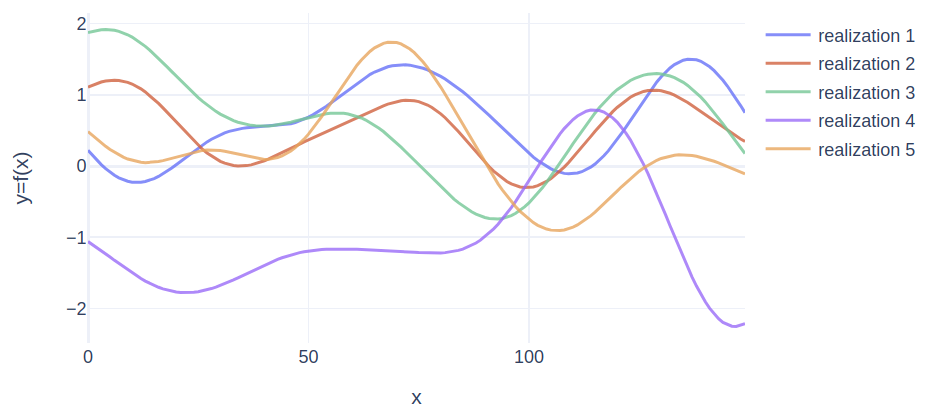

In [15]:
Image("../Resources/img/gp-sampling-rbf.png")

Using Gaussian Process for regression is a three step process:

1. Define a prior kernel function
2. Create a posterior distribution, given some data and likelihood function
3. Generate predictions ($y$) for the input variables ($X$)

To make predictions $y_2=f(X_2)$, one would draw samples from the posterior distribution $p(y_2|y_1,X_1,X_2)$:

$$
\begin{bmatrix} y_1 \\ y_2 \end{bmatrix} \sim \mathcal{N}\left(\begin{bmatrix} \mu_1 \\ \mu_2 \end{bmatrix}, \begin{bmatrix} \Sigma_{11} & \Sigma_{12} \\ \Sigma_{21} & \Sigma_{22} \end{bmatrix}\right)
$$

and then use the conditional distribution:

$$
\mu_{2|1}=(\Sigma^{-1}_{11} \Sigma_{12})^T y_1
$$

$$
\Sigma_{2|1}=\Sigma_{22}-(\Sigma^{-1}_{12} \Sigma_{12})^T \Sigma_{12}
$$

$y_2$ can be predicted by using mean $\mu_{2|1}$.

The visualization for predictions for a noiseless distribution shows that uncertainty (a salmon-color fill around the sine wave) in the points with data (black dots below) is minimal, but it grows in the sections without any data points:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.10. Gaussian Process predictions and uncertainty</p>

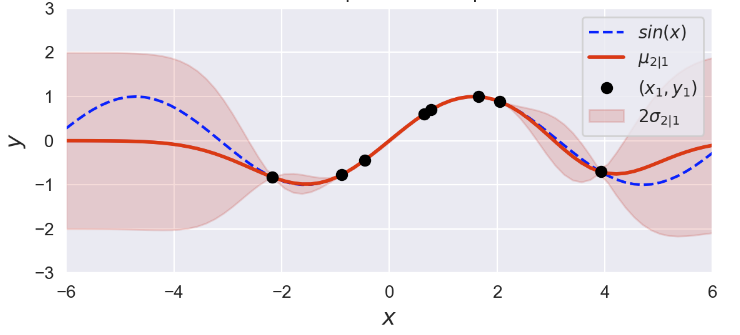

In [16]:
Image("../Resources/img/gp.png")

### 2.2.4. Conclusion

Gaussian processes are a very elegant, robust and informed approach to Machine Learning. One not only generates predictions for unseen data, but also the uncertainty. This can be a very useful tool in the decision making.

However it is important to keep in mind that working with larger datasets can be a **challenge** due to $\mathcal{O}(n^3)$ complexity. In my eyes, certainly Gaussian process algorithms were very slow to train (given that I have only used them with $< 4000$ records) and they have consumed a lot of memory (GPy was much more efficient than pymc3).

There are methods used to decrease the complexity to $\mathcal{O}(n^2)$ and new frameworks continuously work on the improvements (pymc developers are currently switching their back-end to TensorFlow), but training Gaussian Process-based models can be a challenging and time consuming task.

## 2.3. Auto-encoders for Anomaly Detection

One of the core three ideas in this research is *Anomaly Detection*. For example, it could very useful to alert home owners when something out of the ordinary is taking place around their property.

Below is a Literature Review about *auto-encoders*, which are Neural Network models, often used for anomaly detection in the large scale datasets (like image or text data).

Auto-encoder learns to predict (reconstruct) its own inputs, without any prior knowledge of target outputs or labels. It is loosely classified as an unsupervised learning algorithm.

There is a weak evidence of the origins for this Neural Network architecture, which is described in an online *Deep Learning book* <cite data-cite="goodfellow:2016:deep">(Goodfellow et al., 2016)</cite>, where author dates the method back all the way to eighties, even though the terminology and use cases have changed drastically over the years.

In the modern are, auto-encoders are used to achieve several goals, like:

- data compression (dimensionality reduction)
- image de-noising
- anomaly detection
- machine translation

While there are several variants of this type of Neural Network, at a high level it can be represented in a following diagram <cite data-cite="dertat:2017:ae">(Dertat, 2017)</cite>:

<p style="text-align: center; margin-bottom: 0;">Fig. 2.11. Auto-encoder diagram</p>

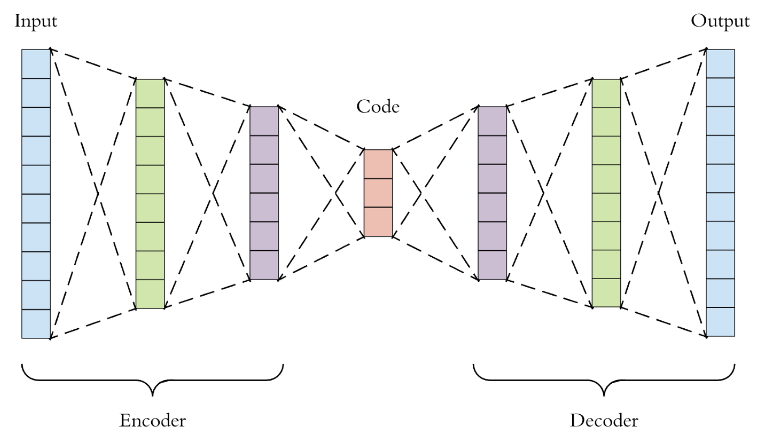

In [17]:
Image("../Resources/img/ae.png")

If the Encoder part is $h=f(x)$, then the Decoder is $r=g(h)$.

The main idea behind this design is to use a Feed-Forward Network to learn to copy the Input, but due to the size-constrained bottleneck layer in the middle, only the most salient characteristics of the data are learned (an auto-encoder, which can learn to reproduce the inputs perfectly would not be very useful).

The learning process is fairly standard and aims to minimize a loss function:

$$
\mathcal{L}(x, g(f(x)))
$$

, where $\mathcal{L}$ can be any differentiable function like *mean squared error*, penalizing $g(f(x))$ from being dissimilar from $x$.

When $MSE$ is used, auto-encoder can be compared to $PCA$ (Principal Component Analysis), but with a non-linear choice for functions $f$ and $g$, it becomes a more powerful non-linear generalization of $PCA$.

There are trade-offs to such a powerful model. As authors of the Deep Learning book conclude, when this model is given too much capacity, it fails to learn anything useful.

Given this challenge, a family of auto-encoder type of models have been developed, with *Variational Auto-encoders* being the most popular one.

## 2.4. Conclusion

Auto-encoders conclude the Literature Review in this research. The knowledge base in the area of object detection, forecasting and anomaly detection is vast with new research papers and articles landing every day, but I hope that the overview above sets the tone on what is to come in the next chapters.

And the next Chapter focuses on the overall **System Design**.

[index](../Index.ipynb) | [prev](./01.Introduction.ipynb) | [next](./03.SystemDesign.ipynb)